# Examen Python Data Developer
# Deel 2

Ga verder met de verwerkte data die je uit deel 1 hebt. We gaan nu op basis van dezelfde dataset een aantal onderzoeksvragen oplossen!

# Utilities

In [1]:
def to_percentage(number):
    return str(np.round(number * 100, 2)) + "%"

def compute_num_unique(df, n_births):
    return len(np.unique(df['naam'].sample(n_births)))

# Loop through all csv's in folder 'data' to collect its data in a dataframe
def read_csvs_from_folder(folder_path):
    '''
    Loop through all files that end with .csv, except for one file 2019-2-29 as the date is non-existing.
    Append the info into a dataframe, along with the file name.
    The file name is the birthdate, and is added as an extra column to the dataframe.
    
    '''
    # Create an empty list to store dataframes
    dfs = []

    # Iterate over each file in the folder
    for file_name in os.listdir(folder_path):
        if file_name.endswith('.csv') and file_name != '2019-2-29.csv':
            # Get the base filename without extension
            file_name_without_extension = os.path.splitext(file_name)[0]
            
            # Read the CSV file into a dataframe
            file_path = os.path.join(folder_path, file_name)
            df = pd.read_csv(file_path)
            
            # Add a new column with the file name
            df['geboortedatum'] = file_name_without_extension
            
            # Append the dataframe to the list
            dfs.append(df)
    
    # Concatenate all dataframes into a single dataframe
    combined_df = pd.concat(dfs, ignore_index=True)
    
    return combined_df

In [2]:
# import libraries
import pandas as pd
import numpy as np
import os
from datetime import datetime#, timedelta
import sys
import matplotlib.pyplot as plt
# import seaborn as sns
# import math
# from scipy.stats import norm

# import standards for plotting and colors
sys.path.append('../scripts')
import plotting_standard
plotting_standard.standard_setup()

# Data inlezen

In [3]:
# Define path where data is located
folder_path = os.path.join('..', 'Data')

# Put content of csv's in a dataframe using loop function
df = read_csvs_from_folder(folder_path)

# Print the combined dataframe to check if load has succeeded
print('Amount of rows in dataframe:', len(df))

# Data of 2019-2-29.csv goes to separate df
name_wrong_csv = '2019-2-29.csv'
df_wrong = pd.read_csv(os.path.join('..', 'data', name_wrong_csv))
print('Amount of rows from wrong csv 2019-2-29.csv in separate df :', len(df_wrong))

Amount of rows in dataframe: 116850
Amount of rows from wrong csv 2019-2-29.csv in separate df : 73


### Onderzoek 1: Unisex namen
#### Een aantal statistieken
Sommige namen zijn unisex, dat wil zeggen dat zij hetzelfde zijn voor mannen en vrouwen. Beantwoord volgende 3 vragen over unisex namen in onze dataset:
 - Hoeveel unisex namen zijn er?
 - Wat is de meest voorkomende unisex naam; hiervoor zoek ik 3 namen (en getallen):
    - De meest populaire unisex naam bij mannen.
    - De meest populaire unisex naam bij vrouwen.
    - De meest popuaire unisex naam.

**Tip:** Neem hiervoor terug de volledige dataset in acht (dus met de foutief geklasseerde namen).

In [4]:
# Add 'geboortedatum' to df_wrong
df_wrong['geboortedatum'] = '2019-2-29'

# concat two df's
df_birth_all = pd.concat([df, df_wrong])
df_birth_all.sample(3)

,gemeente,naam,geslacht,verwachte datum,geboortedatum
102604,Brussel,Tugba,Vrouwelijk,08/20/2019,2019-8-24
112815,Fleurus,Laetitia,Vrouwelijk,09/29/2019,2019-9-25
105395,Colfontaine,Maxence,Mannelijk,08/06/2019,2019-8-4


In [5]:
# Hoeveel unisex namen zijn er?

# Make df with unique rows 'naam' & 'geslacht'
df_names_unique = (df_birth_all[['naam', 'geslacht']]
                   .drop_duplicates(keep='last')
                   .groupby('naam')['geslacht']
                   .nunique()
                   .reset_index()
                  )

# Rename columns for clarity
df_names_unique.columns = ['naam', 'telling geslacht']

# Make df with unisex names
unisex_names = df_names_unique[df_names_unique['telling geslacht'] == 2]['naam']

print(len(unisex_names), 'different unisex names are in the original dataset')

75 different unisex names are in the original dataset


In [6]:
# Make df with occurences of the names
df_name_occurences = df_birth_all[['naam', 'geslacht']]
df_name_occurences['telling naam'] = (df_name_occurences.groupby('naam')['naam'].transform('count'))

# Join unisex_names with df_name_occurences
df_unisex_names = pd.merge(unisex_names, df_name_occurences, on='naam', how='left')
df_unisex_names = df_unisex_names.sort_values(by='telling naam', ascending = False)
df_unisex_names

# Get most popular unisex names (M/F/overall)
print('De meest popuaire unisex bij mannen:')
print(df_unisex_names[df_unisex_names['geslacht'] == 'Mannelijk'].iloc[0:1])
print('')

print('De meest popuaire unisex bij vrouwen:')
print(df_unisex_names[df_unisex_names['geslacht'] == 'Vrouwelijk'].iloc[0:1])
print('')

print('De meest popuaire unisex naam:')
print(df_unisex_names.iloc[0:1])

De meest popuaire unisex bij mannen:
          naam   geslacht  telling naam
900  Dominique  Mannelijk           394

De meest popuaire unisex bij vrouwen:
          naam    geslacht  telling naam
728  Dominique  Vrouwelijk           394

De meest popuaire unisex naam:
          naam    geslacht  telling naam
728  Dominique  Vrouwelijk           394


C:\Users\CarloDieltjens\AppData\Local\Temp\ipykernel_3388\3793452404.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_name_occurences['telling naam'] = (df_name_occurences.groupby('naam')['naam'].transform('count'))


We zien dat er een vrij groot aantal namen veel meer voorkomen bij mannen dan vrouwen (en omgekeerd). Dit vinden we eigenlijk geen "echte" unisex namen. We noemen een naam "echt unisex" als de naam niet meer dan 50% meer voorkomt bij 1 van de 2 geslachten. Dus als er `x` mannen en `y` vrouwen zijn genaamd Chris, dan noemen we Chris "echt unisex" als `x <= 1.5 * y` en `y <= x * 1.5`. Filter je unisex dataframe tot een `df_real_unisex` waarbij je enkel de "echte" unisex namen weerhoudt. 
- Beantwoord nu bovenstaande 3 vragen opnieuw voor deze dataset. Hierbij werk je best met een functie zodat je geen code moet herhalen!
- Zijn de echte unisex namen populairder bij mannen of vrouwen, of is de populariteit hetzelfde? Deze vraag kan je beantwoorden door te kijken naar het percentage mannen/vrouwen met een echte unisex naam.

Populairse echte unisex naam bij de mannen: Dominique
Populairse echte unisex naam bij de vrouwen: Dominique
Populairse echte unisex naam in het algemeen: Dominique


75        Adama
196      Alexis
272        Amel
281       Amine
314      Andrea
         ...   
5079        Yan
5086    Yannick
5119      Yentl
5121         Yi
5135       Yoni
Name: naam, Length: 75, dtype: object

In [93]:
df_name_occurences_f.sample()

,naam,geslacht,telling naam,telling naam vrouw
29141,Camille,Vrouwelijk,170,1


In [41]:
df_name_occurences_m.sample()

,naam,geslacht,telling naam
66997,Karl,Mannelijk,34


<!-- #### Make df_real_unisex -->

In [92]:
# Make df filtered on 'Mannelijk' and 'Vrouwelijk'
df_name_occurences_m = df_name_occurences[df_name_occurences['geslacht'] == 'Mannelijk'].copy()
df_name_occurences_f = df_name_occurences[df_name_occurences['geslacht'] == 'Vrouwelijk'].copy()

# Deduplicate these two df's
df_name_occurences_m = df_name_occurences_m.sort_values(by='naam').drop_duplicates(keep='last')
df_name_occurences_f = df_name_occurences_f.sort_values(by='naam').drop_duplicates(keep='last')

# calculate occurence of the names for the two df's
df_name_occurences_m['telling naam man'] = (df_name_occurences_m.groupby('naam')['naam'].transform('count'))
df_name_occurences_f['telling naam vrouw'] = (df_name_occurences_f.groupby('naam')['naam'].transform('count'))


# join df_unisex_names with two gender df's to get the numbers in two extra columns
df_name_extra = (pd.merge(df_names_unique, df_name_occurences_m[['naam','telling naam']], on='naam', how='left')
                 .rename(columns={
                 #     'telling naam_x':'telling allen',
                     'telling naam':'telling naam man'})
                )

df_name_extra = (pd.merge(df_name_extra, df_name_occurences_f[['naam','telling naam vrouw']], on='naam', how='left')
                 .rename(columns={
                     # 'telling naam_x':'telling allen',
                     'telling naam':'telling naam vrouw',
                     # 'geslacht_y': 'geslacht'
                 })
                )

df_name_extra.tail(50)

# df_name_occurences_f

# # # # Add columns share of 'telling vrouw' divided by 'telling man' and vice versa
# df_name_extra['telling vrouw / telling man'] = df_name_extra['telling naam vrouw'] / df_name_extra['telling naam man']
# df_name_extra['telling man / telling vrouw'] = df_name_extra['telling naam man'] / df_name_extra['telling naam vrouw']

# df_name_extra.sample(50)

# # Make new df_real_unisex that is filtered on both shares < 1.5
# # Mind this df has two rows for every names
# df_real_unisex = df_name_extra[(df_name_extra['telling vrouw / telling man'] <= 1.5)] #& (df_name_extra['telling man / telling vrouw'] <= 1.5)]
# df_real_unisex

,naam,telling geslacht,telling naam man,telling naam vrouw
5206,Zeyad,1,1.0,NaN
5207,Zeyneb,1,NaN,1.0
5208,Zeynep,1,NaN,1.0
5209,Zhana,1,NaN,1.0
5210,Zhour,1,NaN,1.0
5211,Zia,1,NaN,1.0
5212,Ziad,1,1.0,NaN
5213,Zilan,1,NaN,1.0
5214,Zinab,1,NaN,1.0
5215,Zine,1,1.0,NaN


In [181]:
df_names_unique.sample(3)

,naam,geslacht
1533,Fe,1
1131,Dimo,1
4756,Taner,1


#### Answer 3 questions from above using a function

In [180]:
def print_popular_names(df): 
    # Get most popular unisex names (M/F/overall)
    print('De meest popuaire unisex bij mannen:')
    print(df[df['geslacht'] == 'Mannelijk'].iloc[0:1,0])
    print('')
    
    print('De meest popuaire unisex bij vrouwen:')
    print(df[df['geslacht'] == 'Vrouwelijk'].iloc[0:1,0])
    print('')
    
    print('De meest popuaire unisex naam:')
    print(df.iloc[0:1,0])

print_popular_names(df_real_unisex)

De meest popuaire unisex bij mannen:
Series([], Name: naam, dtype: object)

De meest popuaire unisex bij vrouwen:
Series([], Name: naam, dtype: object)

De meest popuaire unisex naam:
75    Adama
Name: naam, dtype: object


Percentage mannen met unisex naam: 0.4%
Percentage vrouwen met unisex naam: 0.5%


#### Visualizatie

Maak een visualizatie die alle echte unisex namen toont en de relatieve voorkomens bij mannen en vrouwen.

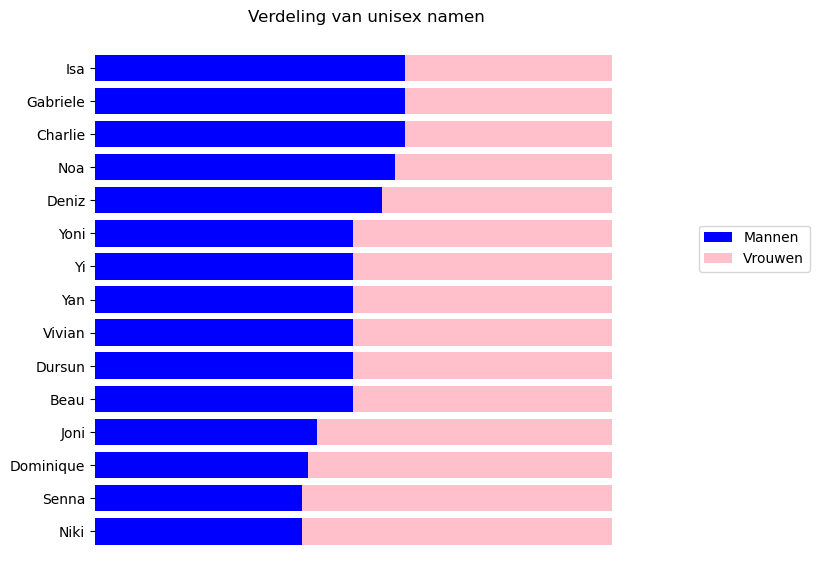

### Onderzoek 2: de accuraatheid van de geschatte bevallingsdatum
#### Evolutie vergelijken

Maak een afbeelding van het totaal aantal geboortes per dag en het totaal aantal verwachte geboortes.

**Bonusvraag**: Gewoon om over na te denken: waarom zien de uiteindes van je plot er wat gek uit? Schrijf het antwoord neer in een strategisch geplaatste markdown cel.

#Bonusvraag:
De x-as is berekend op het aantal effectieve geboortes en niet het verwachte aantal geboortes. Verder bevat de dataset slechts data van 1 jaar.

1/ het uiteinde van de plot langs rechts gaat naar beneden omdat er bij de vrouwen die effectief bevallen zijn, altijd vrouwen zijn die later bevallen. De vrouwen die uitgerekend zijn voor het volgende jaar, zitten niet in de cijfers van de verwachte bevallingen van het weergegeven jaar.

2/ het uiteinde van de plot langs links bij verwachte geboortes vertrekt van een lager getal, en gaat pas na enkele dagen op niveau van effectieve geboortes. Een aantal vrouwen zijn al bevallen in het jaar ervoor en zullen daarom niet voorkomen in het jaar erna. 

De curve links is minder stijl dan de curve rechts omdat er meer vrouwen vroeger bevallen dan dat er vrouwen zijn die later bevallen. Vrouwen die later bevallen krijgen in veel gevallen een 'deadline' waarbij ze de bevalling kunstmatig in gang zetten.

#### Verbanden bekijken
Maak een histogram van het aantal dagen dat babies te vroeg geboren werden in 2019 en een scatterplot die het verband toont tussen de verwachte en effectieve geboortedatum.

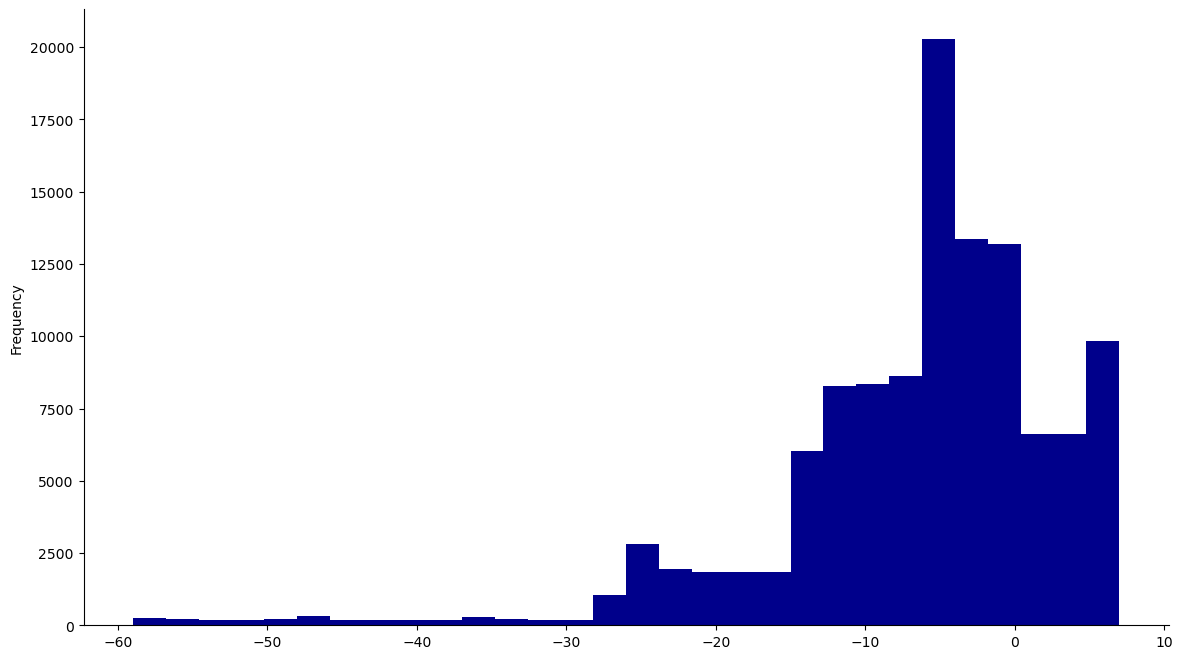

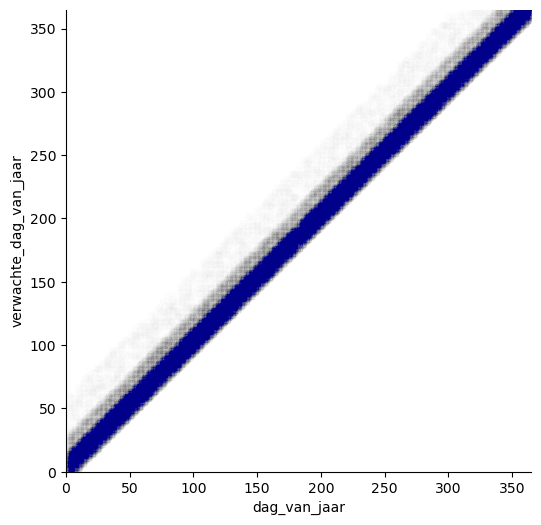

### Onderzoek 3: Aantal namen versus aantal babies
Naarmate dat er meer babies geboren worden, gaan deze ook meer verschillende namen krijgen. Zolang er weinig babies geboren worden lijkt het logisch dat dit verband min of meer lineair is, maar naarmate dat er meer en meer babies geboren worden lijkt het niet meer logisch dat dit verband lineair blijft. We verwachten bijvoorbeeld niet dat het aantal unieke namen gegeven aan 2 miljoen babies het dubbel is van het aantal unieke namen gegeven aan 1 miljoen babies. Kan je op basis van deze dataset het verband tussen het aantal unieke namen in functie van het aantal babies eens onderzoeken? Hiervoor krijg je geen voorstel tot visualizatie maar moet je zelf mij proberen te overtuigen van je antwoord.